## Download Models

In [1]:
!gdown --folder https://drive.google.com/drive/folders/1Cp2Mc9G-BfzZKFmSEYnosazE_2VZHX-1?usp=sharing
!rm -r sample_data

Retrieving folder contents
Processing file 1gV9ODoQeG9AYA0FSQFSKjRJ_c_r1yK4n disc_step_104000.weights.h5
Processing file 1yxDOdMrhC2UuUxbggbduJHCtNSnBeq31 gen_step_104000.weights.h5
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1gV9ODoQeG9AYA0FSQFSKjRJ_c_r1yK4n
To: /content/models/disc_step_104000.weights.h5
100% 11.1M/11.1M [00:00<00:00, 21.4MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1yxDOdMrhC2UuUxbggbduJHCtNSnBeq31
From (redirected): https://drive.google.com/uc?id=1yxDOdMrhC2UuUxbggbduJHCtNSnBeq31&confirm=t&uuid=e1796346-a94c-4694-ba5f-e6fbcc259c31
To: /content/models/gen_step_104000.weights.h5
100% 218M/218M [00:09<00:00, 23.7MB/s]
Download completed


$$$$

**Imports**

In [3]:
import tensorflow as tf

import os
import pathlib
import time
import datetime
import numpy as np
import pandas as pd
from random import shuffle

from matplotlib import pyplot as plt
import seaborn as sns
from IPython import display
from PIL import Image

## Data Pipeline

In [4]:
dataset_name = "facades" #@param ["cityscapes", "edges2handbags", "edges2shoes", "facades", "maps", "night2day"]

In [5]:
class PatchGanDataset():
  """
   Creates a tf.dataset for pix2pix Model

   Arguments:
      dataset_name (str): dataset name, the name is icluded in the URL of the dataset

   Returns:
      dataset (tf.data.Dataset): dataset containing (input_image,real_image)
  """
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self,dataset_name):
    self.dataset_name = dataset_name
    # The batch size of 1 produced better results for the U-Net
    # in the original pix2pix experiment
    self.BATCH_SIZE = 1
    # Each image is 256x256 in size
    self.IMG_WIDTH = 256
    self.IMG_HEIGHT = 256
    self.PATH = None


  def load_dataset(self,):
    _URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{self.dataset_name}.tar.gz'

    path_to_zip = tf.keras.utils.get_file(
        fname=f"{self.dataset_name}.tar.gz",
        origin=_URL,
        extract=True)

    path_to_zip  = pathlib.Path(path_to_zip)

    self.PATH = path_to_zip.parent/dataset_name
    return self.PATH

  # Loads an image for a given path
  def load_image(self, path):
    ## Reads image from path and decode it to the jpeg format
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img)

    ## split the image into mask, real
    w = tf.shape(img)[1]
    w = w // 2
    re_img = img[:,:w,:]
    mask_img = img[:,w:,:]

    ## convert both images to float32 images
    re_img = tf.cast(re_img, tf.float32)
    mask_img = tf.cast(mask_img, tf.float32)

    return mask_img,re_img


  # Randomly Crop an image to the original size (256,256,3)
  def random_crop(self, input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, self.IMG_HEIGHT, self.IMG_WIDTH, 3])

    return cropped_image[0], cropped_image[1]


  # Normalizing the images to [-1, 1]
  def normalize(self, input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

  # Resize an image given its height and width
  def resize(self, input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width],
                                  method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return input_image, real_image


  @tf.function()
  def random_jitter(self, input_image, real_image):
    # Resizing to 286x286
    input_image, real_image = self.resize(input_image, real_image, 286, 286)

    # Random cropping back to 256x256
    input_image, real_image = self.random_crop(input_image, real_image)

    if tf.random.uniform(()) > 0.5:
      # Random mirroring
      input_image = tf.image.flip_left_right(input_image)
      real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image


  def load_image_train(self, image_file):
    input_image, real_image = self.load_image(image_file)
    input_image, real_image = self.random_jitter(input_image, real_image)
    input_image, real_image = self.normalize(input_image, real_image)

    return input_image, real_image


  def load_image_test(self, image_file):
    input_image, real_image = self.load_image(image_file)
    input_image, real_image = self.resize(input_image, real_image,
                                    self.IMG_HEIGHT, self.IMG_WIDTH)
    input_image, real_image = self.normalize(input_image, real_image)

    return input_image, real_image

  def create_dataset(self,files=[]):
    dataset = tf.data.Dataset.list_files(files)
    dataset = dataset.shuffle(len(dataset))
    dataset = dataset.map(self.load_image_train,
                                      num_parallel_calls=tf.data.AUTOTUNE)

    dataset = dataset.batch(self.BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [6]:
@PatchGanDataset.add_method
def __call__(self,rows=2,pad_color=40):
  """
   Visualize a random set of images from the train Dataset

   Arguments:
      rows (int): number of rows of the displayed image

   Returns:
      image (Image)
  """
  if rows % 2 !=0:
    print('[!] rows must be an odd number')
    return

  train_paths = self.PATH.rglob('train/*.jpg')
  train_paths = [str(x) for x in train_paths]
  candidates = np.random.choice(train_paths,size=2*rows,replace=False)
  pad = tf.ones(shape=(8,1024,3),dtype=tf.uint8) * pad_color

  sample_images = [tf.io.read_file(x) for x in candidates]
  sample_images = [tf.io.decode_jpeg(x) for x in sample_images]
  sample_images = [tf.concat([tf.concat(x,axis=1),pad],axis=0) for x in zip(sample_images[::2],sample_images[1::2])]
  sample_images = tf.concat(sample_images,axis=0)
  required_shape = sample_images.shape[0]-pad.shape[0]
  sample_images = sample_images[:required_shape,:,:]

  return Image.fromarray(sample_images.numpy())

In [7]:
Dataset = PatchGanDataset(dataset_name=dataset_name)
PATH = Dataset.load_dataset()
PATH

30168306/30168306 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


PosixPath('/root/.keras/datasets/facades')

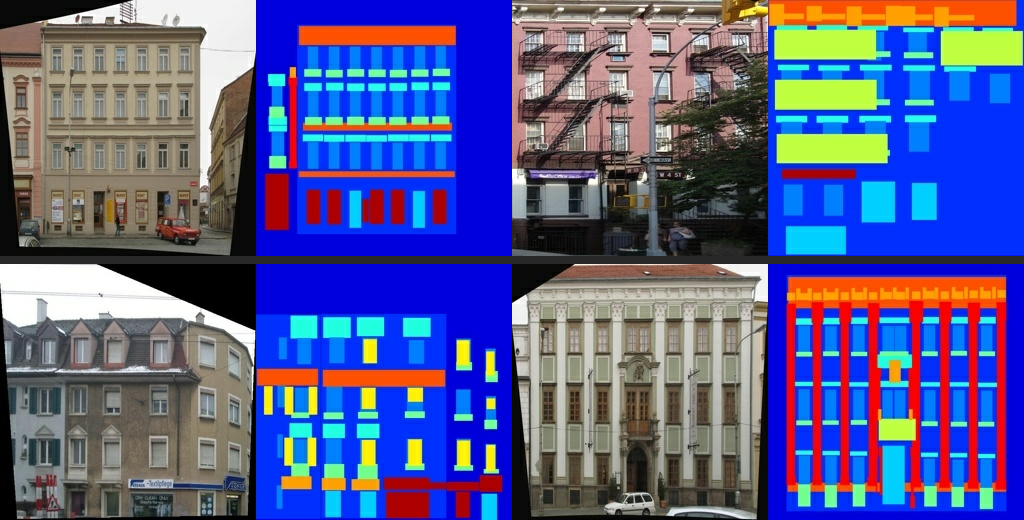

In [8]:
Dataset()

In [9]:
train_files = list((PATH / 'train').glob('*.jpg')) + list((PATH / 'val').glob('*.jpg'))
test_files= list((PATH / 'test').glob('*.jpg'))
shuffle(test_files)
_, test_files  = test_files[:80], test_files[80:]
train_files += _
train_files = list(map(str, train_files))

train_dataset = Dataset.create_dataset(files=train_files)

print(f'train_dataset:\n {train_dataset.element_spec}')
print(f'[!] len of train_dataset: {len(train_dataset)}')

print(f'[!] len of test_dataset: {len(test_files)}')

train_dataset:
 (TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))
[!] len of train_dataset: 580
[!] len of test_dataset: 26


$$$$

## Model Architecture

### Generator

In [11]:
class DownSample(tf.keras.layers.Layer):

  def __init__(self,filters, kernel_size=4, batchnorm=True):
    super().__init__()
    self.seq = tf.keras.models.Sequential()
    self.conv = tf.keras.layers.Conv2D(filters=filters,
                                       kernel_size=kernel_size,
                                       strides=2,
                                       use_bias=False,
                                       padding='same')
    self.seq.add(self.conv)
    if batchnorm:
      self.BatchNorm = tf.keras.layers.BatchNormalization()
      self.seq.add(self.BatchNorm)
    self.activation = tf.keras.layers.LeakyReLU()
    self.seq.add(self.activation)

  def call(self,x):
    return self.seq(x)

class Encoder(tf.keras.layers.Layer):
  """
   encoder part of the UNET architecture
   an ensemble of DownSample blocks
  """
  def __init__(self, size=64):
    super().__init__()
    self.downsampling = []
    self.downsampling.append(DownSample(size,batchnorm=False))   # (batch_size,128,128,64)
    self.downsampling.append(DownSample(size*2))                # (batch_size,64,64,128)
    self.downsampling.append(DownSample(size*4))                # (batch_size,32,32,256)

    self.downsampling += [DownSample(size*8) for i in range(5)]    # (batch_size,1,1,512)


  def call(self, x):
    stacks = []
    for downsample in self.downsampling:
      x = downsample(x)
      stacks.append(x)

    return x,stacks

class UpSample(tf.keras.layers.Layer):
  """
   upsample an image
  """
  def __init__(self,filters,
               size=4,
               dropout_rate=0):
    super().__init__()
    # sequantial
    self.seq = tf.keras.models.Sequential()
    # Conv Transpose
    self.initializer = tf.random_normal_initializer(0., 0.02)
    self.deconv = tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    kernel_initializer=self.initializer,
                                    padding='same',
                                    use_bias=False)
    # Batch Norm
    self.batchnorm = tf.keras.layers.BatchNormalization()
    self.seq.add(self.deconv)
    self.seq.add(self.batchnorm)
    # Dropout
    if dropout_rate>0:
      self.dropout = tf.keras.layers.Dropout(dropout_rate)
      self.seq.add(self.dropout)
    # Activation
    self.activation = tf.keras.layers.ReLU()
    self.seq.add(self.activation)

  def call(self,x):
    return self.seq(x)

class Decoder(tf.keras.layers.Layer):
  """
   Decoder part of the UNET architecture
  """

  def __init__(self,size=512,dropout_rate=0.5):
    super().__init__()
    self.upsampling = []

    self.upsampling.append(UpSample(size,dropout_rate=dropout_rate))   # (batch_size,2,2,512)
    self.upsampling.append(UpSample(size,dropout_rate=dropout_rate))  # (batch_size,4,4,512)
    self.upsampling.append(UpSample(size,dropout_rate=dropout_rate))  # (batch_size,8,8,512)
    self.upsampling.append(UpSample(size))                # (batch_size,16,16,512)
    self.upsampling += [UpSample(size//(2**i)) for i in range(1,4)]     # ((batch_size,128,128,64))

    self.last = tf.keras.layers.Conv2DTranspose(3,4,
                                                strides=2,
                                                padding='same',
                                                activation='tanh'
                                                )

  def call(self, x):
    skips = reversed(x[:-1])
    x = x[-1]

    for up,skip in zip(self.upsampling,skips):
      x = up(x)
      x = tf.keras.layers.Concatenate()([x,skip])

    x = self.last(x)
    return x

class Generator(tf.keras.Model):
  """
    generate a real image given a mask image
  """
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self,dropout_rate=0.5):
    super().__init__()
    self.encoder = Encoder()
    self.decoder = Decoder(dropout_rate=dropout_rate)

  def call(self,x):
    """
      Arguments:
          x (tf.Tensor): mask image of shape (1,256,256,3)

      Returns:
          img (tf.Tensor): real image of shape (1,256,256,3)
    """
    encoding,stacks = self.encoder(x)
    img = self.decoder(stacks)
    return img

### Discriminator

In [10]:
class Discriminator(tf.keras.Model):
  """
   Classifies each Patch of image as Real or Fake

  """
  def __init__(self,size=64):
    super().__init__()
    self.concat = tf.keras.layers.Concatenate()

    self.down1 = DownSample(size,batchnorm=False)
    self.down2 = DownSample(size*2)
    self.down3 = DownSample(size*4)

    self.zero_pad1 = tf.keras.layers.ZeroPadding2D()

    self.conv = tf.keras.layers.Conv2D(512,4,
                                       strides = 1,
                                       use_bias=False
                                       )

    self.batchnorm = tf.keras.layers.BatchNormalization()
    self.activation = tf.keras.layers.LeakyReLU()
    self.zero_pad2 = tf.keras.layers.ZeroPadding2D()
    self.last = tf.keras.layers.Conv2D(1,4,strides=1)

    self.seq = tf.keras.Sequential([
        self.down1,
        self.down2,
        self.down3,
        self.zero_pad1,
        self.conv,
        self.batchnorm,
        self.activation,
        self.zero_pad2,
        self.last
    ])

  def call(self,inp,tar):
    """
     Argumenst:
        inp (tf.Tensor): mask image of shape (1,256,256,3)
        tar (tf.Tensor): generated image of shape (1,256,256,3)

     Returns:
        patch (tf.Tensor): a tensor of shape (1,30,30,1) , each pixel classidfies a patch of 70*70 from the tar image
    """
    x = self.concat([inp,tar])
    patch = self.seq(x)
    return patch

### Generator Generate Method

In [12]:
@Generator.add_method
def generate(self,inp,tar=None,training=True):

  fake = self(inp[tf.newaxis,...],training=training)
  fake = tf.squeeze(fake)

  # Visualise
  plt.figure(figsize=(12,12))
  display_list = [inp, tar, fake] if tar is not None else [inp, fake]
  title = ['Input Image','Ground Truth','Generated Image'] if tar is not None else ['Input Image','Generated Image']

  for i in range(len(title)):
    plt.subplot(1, len(title), i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

### Create Model

In [13]:
dropout_rate = 0.5 # @param {"type":"slider","min":0,"max":1,"step":0.05}
# controls the diversity of the model
# higher value of dropout means more diversity
gen = Generator(dropout_rate=dropout_rate)
disc = Discriminator()

**build model before loading weights**

In [14]:
mask,img = next(iter(train_dataset))
fake_image = gen(mask,training=True)
disc_generated_output = disc(mask,fake_image)

**load model checkpoint**

In [15]:
checkpoint_to_restore = f'./models/gen_step_104000.weights.h5'
gen.load_weights(checkpoint_to_restore)
checkpoint_to_restore = f'./models/disc_step_104000.weights.h5'
disc.load_weights(checkpoint_to_restore)

print(f"Model weights restored successfully!!")

Model weights restored successfully!!


$$$$

## Generate Images

In [16]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [17]:
def gen_and_plot(gen,disc,heatmap=False):
    start = time.time()
    path = str(np.random.choice(train_files))
    inp,_ = Dataset.load_image_test(path)
    fake_image = gen(inp[tf.newaxis,...],training=True)
    print(f'generation time: {(time.time()-start):.3f} seconds')
    disc_generated_output = disc(inp[tf.newaxis,...],fake_image)

    # vis
    figsize=(12,4) if heatmap else (8,4)
    cols=3 if heatmap else 2
    plt.figure(figsize=figsize)

    plt.subplot(1,cols,1)
    inp = tf.squeeze(inp)
    inp = inp*0.5+0.5
    plt.imshow(inp)
    plt.axis('off')
    plt.subplot(1,cols,2)
    fake = tf.squeeze(fake_image)
    fake = fake*0.5+0.5
    plt.imshow(fake)
    plt.axis('off')
    if heatmap:
        plt.subplot(1,3,3)
        FakeMap = (disc_generated_output - disc_generated_output.numpy().min())/(disc_generated_output.numpy().max()-disc_generated_output.numpy().min())
        FakeMap = tf.squeeze(FakeMap)
        plt.imshow(FakeMap,cmap='RdBu_r')
        plt.axis('off')
    plt.show()
    print(f'elapsed time: {(time.time()-start):.3f} seconds')
    disc_score = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output).numpy()
    disc_score = disc_score.item()
    print(f'Disc score on the generated image: {disc_score:.4f}')
    print(f'[!] the higher the better')
    return fake_image

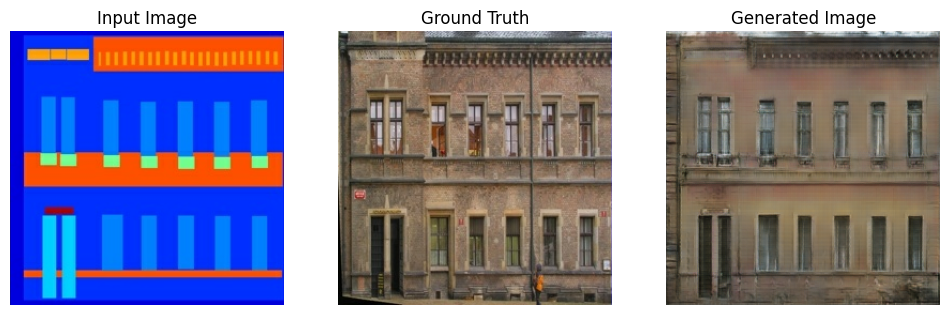

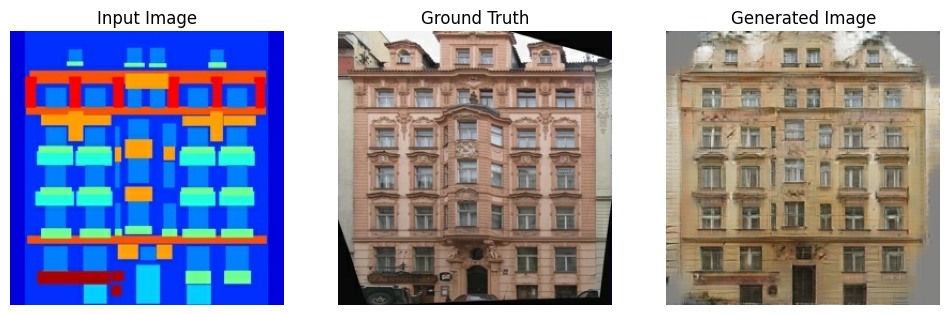

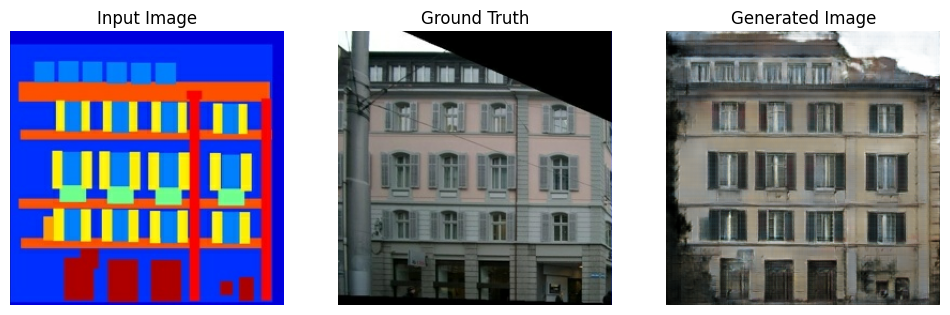

In [18]:
paths = np.random.choice(test_files,3,replace=True)
paths = list(map(str,paths))
for path in paths:
    inp,tar = Dataset.load_image_test(path)
    gen.generate(inp, tar=tar)
    print()

generation time: 0.714 seconds


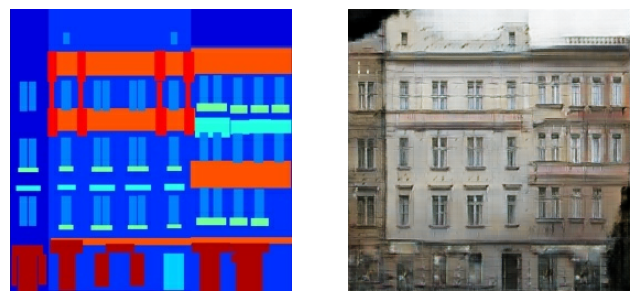

elapsed time: 1.254 seconds
Disc score on the generated image: 0.2407
[!] the higher the better


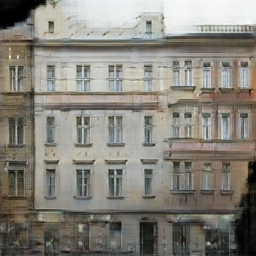

In [19]:
fake_image = gen_and_plot(gen,disc)
fake = (fake_image+1)*127.5
fake = fake.numpy().astype(np.uint8)
fake = np.squeeze(fake)
Image.fromarray(fake)

**Plot Disciminator Heatmap**

generation time: 1.162 seconds


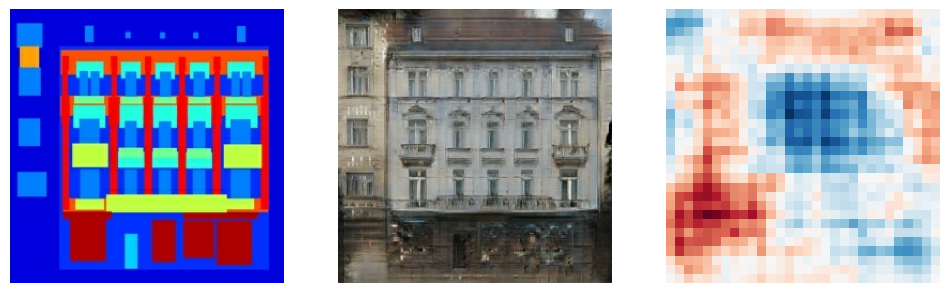

elapsed time: 2.245 seconds
Disc score on the generated image: 0.3474
[!] the higher the better
CPU times: user 1.29 s, sys: 44 ms, total: 1.34 s
Wall time: 2.26 s


In [20]:
%%time
_ = gen_and_plot(gen,disc,heatmap=True)

> The Disciminator score tells how good the generated image is, the higher the score the better (higher score indicates that the disciminator can't tell the difference from a fake image and a real one)

$$$$

## Run Model on created masks (out of domain images)

**I've developed a web-based [interface](https://seddik-turki.github.io/Sketch2Image/app.html) hosted on my [github](https://github.com/Seddik-Turki/Sketch2Image) which serves as a tool for creating building facades by drawing on a canvas, which can then be fed to the model for generating real building images.**

In [21]:
!gdown 15iFsVo-_ez-S4tCUlVODA_BGiUEvRgD6 # canvas1
!gdown 1az5cdHffsrVaOdAh0FbvI23iswhrNGaH # canvas2

Downloading...
From: https://drive.google.com/uc?id=15iFsVo-_ez-S4tCUlVODA_BGiUEvRgD6
To: /content/canvas_image.png
100% 7.75k/7.75k [00:00<00:00, 23.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1az5cdHffsrVaOdAh0FbvI23iswhrNGaH
To: /content/canvas_image_1.png
100% 6.66k/6.66k [00:00<00:00, 19.8MB/s]


In [22]:
def generate(path):
    # load and preprocess
    mask = Image.open(path).convert('RGB')
    mask = mask.resize((256,256))
    mask = np.array(mask)
    mask = tf.convert_to_tensor(mask)
    mask = tf.cast(mask,tf.float32)
    mask = (mask / 127.5) - 1
    mask = mask[tf.newaxis,...]
    # generate and plot
    genrated_image  = gen(mask,training=True)
    out = tf.squeeze(genrated_image)
    out = (out+1)*127.5
    out = out.numpy().astype(np.uint8)
    # disciminator
    disc_generated_output = disc(mask,genrated_image)
    score = loss_object(tf.zeros_like(disc_generated_output),
                        disc_generated_output).numpy()
    score = score.item()
    print(f'Discriminator score on the generated image: {score:.4f}')
    return out

Discriminator score on the generated image: 0.1359


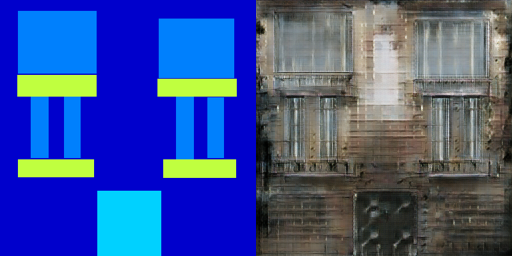

In [23]:
mask = Image.open('./canvas_image.png').convert('RGB')
mask = mask.resize((256,256))
mask = np.array(mask)
generated_image = generate('./canvas_image.png')
output = np.concatenate([mask,generated_image],axis=1)
Image.fromarray(output)

Discriminator score on the generated image: 0.1490


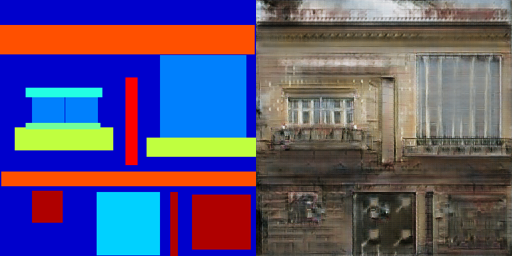

In [24]:
mask = Image.open('./canvas_image_1.png').convert('RGB')
mask = mask.resize((256,256))
mask = np.array(mask)
generated_image = generate('./canvas_image_1.png')
output = np.concatenate([mask,generated_image],axis=1)
Image.fromarray(output)